# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import pendulum

import tensorflow as tf
from transformers import TFAutoModel

In [2]:
# helper function to print the classification report and confusion matrix
def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

# helper function to plot the confusion matrix
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

# Load Data

We performed our lemmatization in the EDA notebook and have full and partial dataframes saved on disk to load. Here we are loading from the reviews and synopsis lemmed data just the target and the review text. We have acccess to both the original text and the cleaned/lemmatized text depending on which modeling technique we're using.

Since the last thing being attempted was BERT modeling we used the raw review text, but the lemmatized text was used for baseline and bag of words modeling.

In [3]:
# loading the original text from the data. can load the lemmed text by adding '_lemmed' to the end of 
# review_text
large_df = pd.read_parquet('./data/reviews_synopsis_lemmed.parquet', columns=['is_spoiler',
                                                                              'review_text',
                                                                              'review_text_lemmed'
                                                                             ])
large_df

,is_spoiler,review_text
0,1,The second Tom Clancy novel made into a film (...
1,1,The second in what looks like becoming the 'Ja...
2,1,I was not a fan of The Hunt For Red October. I...
3,1,Jack Ryan (Harrison Ford) is a CIA analyst who...
4,1,This was one of the big summer movies of 1992....
...,...,...
538777,0,Dunkirk is a beautifully done movie that has h...
538778,0,Dunkirk is one of the rare cases a film receiv...
538779,0,Film gave insufficient background on what was ...
538780,0,"In screen writing, a shot is an image captured..."


## train/val/test split

In [4]:
# set predictor to the review text, target to is_spoiler
predictor = large_df.review_text
target = large_df.is_spoiler

# We want 10% of our data for test and 10% for validation, generate our holdout number
holdout = round(len(predictor) * 0.1)

# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(predictor, target, random_state=42, test_size=holdout, stratify=target)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout, stratify=y_trainval)

# delete the large dataframe, predictor, target and trainval variables (no longer needed)
del predictor, target, X_trainval, y_trainval

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

X_train / y_train shapes: (431026,), (431026,)
X_val / y_val shapes: (53878,), (53878,)
X_test / y_test shapes: (53878,), (53878,)


# Baseline Model

For the baseline model we decided to keep it extremely simple and say that any review that contains the word 'spoiler' was, in fact, a spoiler.

In [8]:
# make a baseline dataframe with just the target and the review_text
baseline_df = large_df[['is_spoiler', 'review_text_lemmed']].copy()

# we don't need the large_df anymore
del large_df

# create a new boolean value for reviews that contain the word 'spoiler'
baseline_df['contains_spoiler'] = baseline_df.review_text_lemmed.str.contains('spoiler')
baseline_df['contains_spoiler'] = baseline_df.contains_spoiler.astype(int)

              precision    recall  f1-score   support

  no_spoiler       0.76      0.98      0.85    395686
     spoiler       0.72      0.13      0.22    143096

    accuracy                           0.75    538782
   macro avg       0.74      0.55      0.54    538782
weighted avg       0.75      0.75      0.68    538782



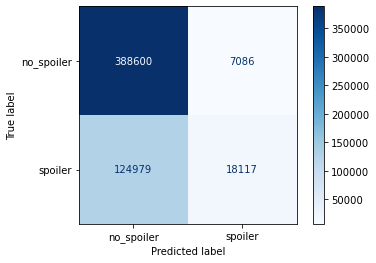

In [9]:
report(baseline_df.is_spoiler, baseline_df.contains_spoiler)

# Bag of Words

We wanted to make it easy to vectorize with different parameters and test the resulting data with a variety of models. The cell below contains two helper functions. The first transforms the X_train and X_val sets with the vectorizer we choose. The second function utilizes the first, and then feeds the resulting transformed data into the fitpredreport function defined in our imports. This way we can run a text on these three modeling techniques efficiently.

In [6]:
# helper function to transform the training and validation data
def transformX(vectorizer, train=X_train, val=X_val, train_target=y_train, val_target=y_val):
    # fit/transform training data
    train_vec = vectorizer.fit_transform(train)
    train_vec = pd.DataFrame.sparse.from_spmatrix(train_vec)
    train_vec.columns = sorted(vectorizer.vocabulary_)
    train_vec.set_index(train_target.index, inplace=True)
    # transform validation data
    val_vec = vectorizer.transform(val)
    val_vec = pd.DataFrame.sparse.from_spmatrix(val_vec)
    val_vec.columns = sorted(vectorizer.vocabulary_)
    val_vec.set_index(val_target.index, inplace=True)
    # return both dataframes
    return train_vec, val_vec

def test_models(vectorizer):
    
    # transfrom X_train and X_val with helper function
    X_train_tfidf, X_val_tfidf = transformX(vectorizer)
    
    # helper function to make fitting, predicting and reporting easier
    def fitpredreport(model):
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        report(y_val, y_pred)
    
    nb = MultinomialNB()
    lr = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
    svm = LinearSVC(random_state=42)
    
    print('Multinomial Naive Bayes')
    fitpredreport(nb)
    print('--------------------------------------------')
    print('Logistic Regression')
    fitpredreport(lr)
    print('--------------------------------------------')
    print('Support Vector')
    fitpredreport(svm)

## base tfidf vectorizer

Vectorizing with no parameter changes. Takes about 3 minutes and generates a vocabulary of 221,997

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       0.76      0.02      0.05     14158

    accuracy                           0.74     53878
   macro avg       0.75      0.51      0.45     53878
weighted avg       0.75      0.74      0.64     53878



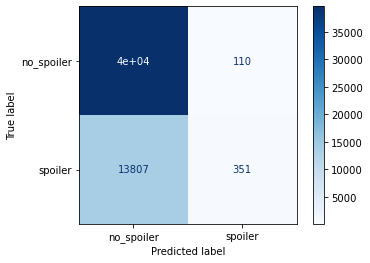

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.36      0.46     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.66     53878
weighted avg       0.75      0.77      0.75     53878



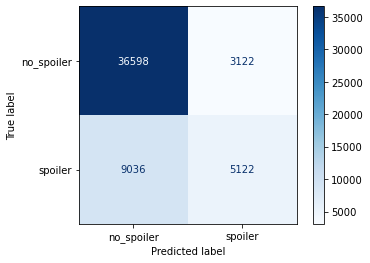

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.35      0.45     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.65     53878
weighted avg       0.75      0.77      0.75     53878



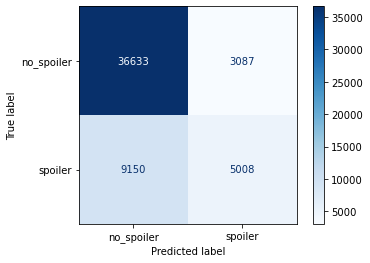

In [8]:
base_tfidf = TfidfVectorizer()

test_models(base_tfidf)

Of the three, the naive bayes model performs the worst, while the logistic regression and the support vector machine models perform similarly, with logistic regression just edging out the SVM model. The model definitely performs better than the simple baseline, but it's not super impressive, barely cracking 36% recall on the spoiler label.

We wanted to try to additional modeling techniques to see how they fared with the data. Knowing they tend to take longer to train we did not include them in the helper function, but will try them now.

### RandomForest / XGBoost

Here we have to break apart the helper function to generate the data to feed into these models to see how the results look.

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       1.00      0.00      0.00     14158

    accuracy                           0.74     53878
   macro avg       0.87      0.50      0.43     53878
weighted avg       0.81      0.74      0.63     53878



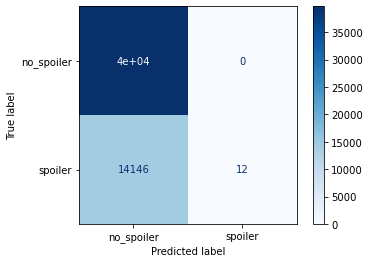

In [12]:
# set tfidf vectorizer, default parameters
base_tfidf = TfidfVectorizer()

X_train_tfidf, X_val_tfidf = transformX(base_tfidf)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

# instantiate random forest classifier
rf_v1 = RandomForestClassifier(max_depth=20, random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v1)

In [15]:
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v1)

MemoryError: Unable to allocate 713. GiB for an array with shape (221997, 431026) and data type float64

The RandomForest model performed terribly, while the XGBoost classifer wouldn't run at all due to memory allocation. We are not going to attempt to model with these for further iteration of vectorizer.

## tfidf vectorizer, min 5

Vectorizing with min_df of 5. Takes about 3 and a half minutes and generates a vocabulary of 75,436.

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.75      0.98      0.85     39569
     spoiler       0.67      0.11      0.19     14309

    accuracy                           0.75     53878
   macro avg       0.71      0.55      0.52     53878
weighted avg       0.73      0.75      0.68     53878



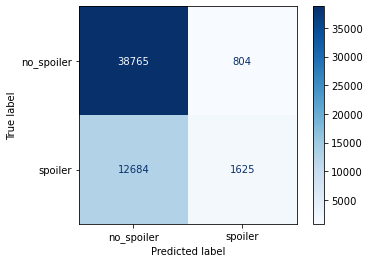

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39569
     spoiler       0.63      0.38      0.47     14309

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.67     53878
weighted avg       0.76      0.78      0.76     53878



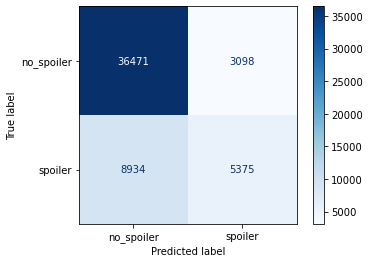

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39569
     spoiler       0.63      0.37      0.47     14309

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.66     53878
weighted avg       0.76      0.78      0.75     53878



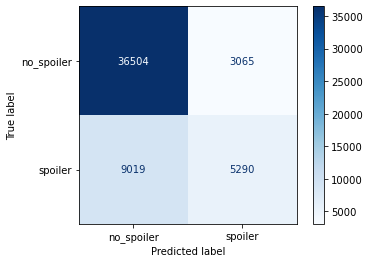

In [7]:
tfidf_min_five = TfidfVectorizer(min_df=5)

test_models(tfidf_min_five)

We certainly see some improvement by restricting the occurance of the words, i.e getting rid of words only used a few times. Lets up the min_df to 8 and see if we can maintain the models performance with an even smaller library

## tfidf vectorizer, min 8

Vectorizing with min_df of 8. Takes about three minutes and generates a vocabulary of 62,746

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.75      0.98      0.85     39569
     spoiler       0.66      0.12      0.21     14309

    accuracy                           0.75     53878
   macro avg       0.71      0.55      0.53     53878
weighted avg       0.73      0.75      0.68     53878



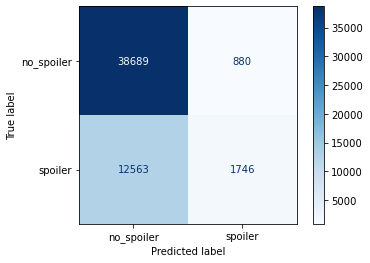

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39569
     spoiler       0.63      0.38      0.47     14309

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.67     53878
weighted avg       0.76      0.78      0.76     53878



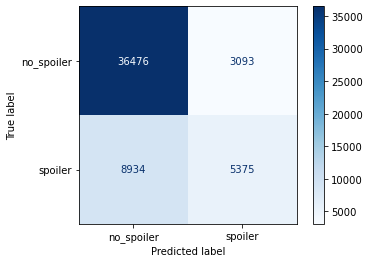

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39569
     spoiler       0.63      0.37      0.47     14309

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.66     53878
weighted avg       0.76      0.78      0.75     53878



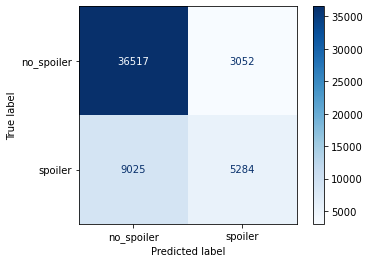

In [10]:
tfidf_min_eight = TfidfVectorizer(min_df=8)

test_models(tfidf_min_eight)

In [11]:
len(tfidf_min_eight.vocabulary_)

62746

Increasing the minimum did improve our model much, save for the naive bayes model (but that 'improvement' is minimal). Lets add in bigrams, keeping our min_df at 8 and see if there can be any more improvement.

## tfidf vectorizer, min 8 adding bigrams

Vectorizing with bigrams and a min_df of 8. Takes about 15 minutes and generates a vocabulary of 987,170

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      0.99      0.85     39569
     spoiler       0.77      0.05      0.10     14309

    accuracy                           0.74     53878
   macro avg       0.76      0.52      0.48     53878
weighted avg       0.75      0.74      0.65     53878



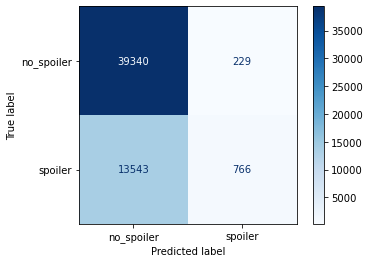

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.92      0.86     39569
     spoiler       0.64      0.40      0.49     14309

    accuracy                           0.78     53878
   macro avg       0.73      0.66      0.68     53878
weighted avg       0.76      0.78      0.76     53878



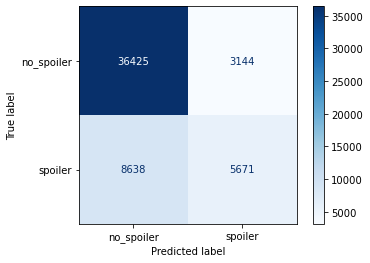

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.81      0.91      0.86     39569
     spoiler       0.61      0.41      0.49     14309

    accuracy                           0.77     53878
   macro avg       0.71      0.66      0.67     53878
weighted avg       0.76      0.77      0.76     53878



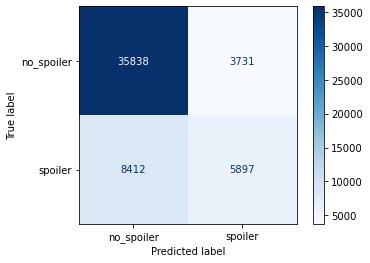

In [12]:
tfidf_min_eight_bi = TfidfVectorizer(min_df=8, ngram_range=(1,2))

test_models(tfidf_min_eight_bi)

Still seeing improvment, but it's kind of plateauing. Lets add in trigrams and see how it looks.

## tfidf vectorizer, min 8 adding trigrams

Vectorizing with trigrams and a min_df of 8. Takes about an hour and generates a vocabulary of 2,322,120

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39569
     spoiler       0.85      0.02      0.03     14309

    accuracy                           0.74     53878
   macro avg       0.79      0.51      0.44     53878
weighted avg       0.77      0.74      0.63     53878



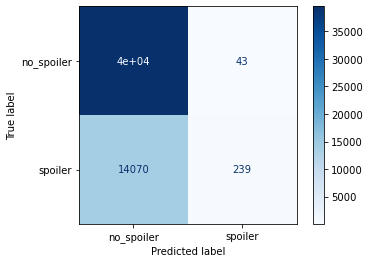

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.93      0.86     39569
     spoiler       0.66      0.39      0.49     14309

    accuracy                           0.78     53878
   macro avg       0.73      0.66      0.68     53878
weighted avg       0.77      0.78      0.76     53878



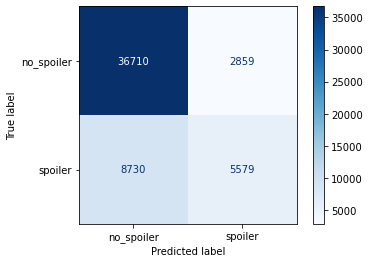

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.81      0.91      0.86     39569
     spoiler       0.63      0.40      0.49     14309

    accuracy                           0.78     53878
   macro avg       0.72      0.66      0.68     53878
weighted avg       0.76      0.78      0.76     53878



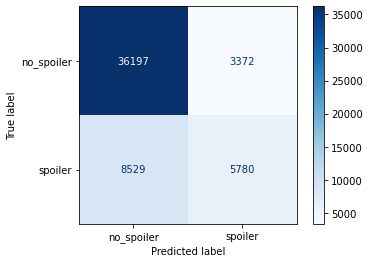

In [16]:
tfidf_min_eight_tri = TfidfVectorizer(min_df=8, ngram_range=(1,3))

test_models(tfidf_min_eight_tri)

# BERT

[Inspiration](https://github.com/jamescalam/transformers/tree/main/course/project_build_tf_sentiment_model)

## preprocessing

In [23]:
large_df

,is_spoiler,review_text
0,1,The second Tom Clancy novel made into a film (...
1,1,The second in what looks like becoming the 'Ja...
2,1,I was not a fan of The Hunt For Red October. I...
3,1,Jack Ryan (Harrison Ford) is a CIA analyst who...
4,1,This was one of the big summer movies of 1992....
...,...,...
538777,0,Dunkirk is a beautifully done movie that has h...
538778,0,Dunkirk is one of the rare cases a film receiv...
538779,0,Film gave insufficient background on what was ...
538780,0,"In screen writing, a shot is an image captured..."


In [22]:
seq_len = 512
num_samples = len(large_df)

num_samples, seq_len

(538782, 512)

In [24]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokens = tokenizer(large_df['review_text'].tolist(),
                   max_length=seq_len,
                   truncation=True,
                   padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [25]:
with open('review-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
    
with open('review-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [ ]:
del tokens

In [26]:
arr = large_df['is_spoiler'].values

In [27]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(538782, 2)

In [29]:
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [30]:
with open('review-labels.npy', 'wb') as f:
    np.save(f, labels)

## input pipeline

In [3]:
with open('review-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('review-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('review-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [5]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [6]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [7]:
# shuffle data and batch it with batch size 256, dropping the remainder that don't fit

batch_size = 256

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(256, 2), dtype=tf.float64, name=None))>

In [8]:
# split data into train and validation, 80/20 split

split = 0.8

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

1683

In [9]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

In [10]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [11]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(256, 2), dtype=tf.float64, name=None))

In [12]:
val_ds.element_spec == train_ds.element_spec

True

## build and train

In [13]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [14]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [16]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into binary output
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(x)

In [17]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [19]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(256, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(256, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(256, 2), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(256, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(256, 2), dtype=tf.float64, name=None))>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
  14/1683 [..............................] - ETA: 196:35:07 - loss: 0.6148 - accuracy: 0.7355